In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

2023-02-05 15:22:16.118605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(["EIN", "NAME"], axis=1)

In [3]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

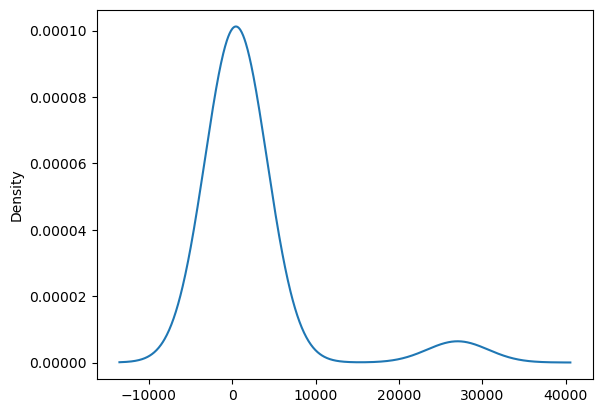

In [5]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [6]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 600].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
Other      804
T8         737
T7         725
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

<AxesSubplot:ylabel='Density'>

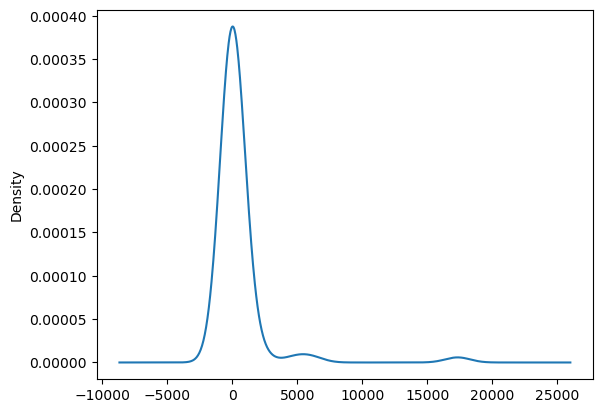

In [8]:
# Visualize the value counts of CLASSIFICATION
classification_counts.plot.density()

In [10]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 3000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
Other     6062
C1200     4837
Name: CLASSIFICATION, dtype: int64

In [11]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

In [12]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

/Users/kristirose/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True).drop(columns=application_cat, axis=1)
application_df

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34295,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34296,1,5000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34297,1,5000,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/Users/kristirose/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [16]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 50

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3280      
                                                                 
 dense_1 (Dense)             (None, 50)                4050      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
_________________________________________________________________


2023-02-05 15:25:13.264909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
#Define the checkpoint path and filenames
os.makedirs('checkpoints/',exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5)

In [19]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 3s 2ms/step - loss: 0.5748 - accuracy: 0.7241
Epoch 2/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5609 - accuracy: 0.7272
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5572 - accuracy: 0.7275
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5560 - accuracy: 0.7294
Epoch 5/100
794/804 [============================>.] - ETA: 0s - loss: 0.5541 - accuracy: 0.7291
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5543 - accuracy: 0.7292
Epoch 6/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5536 - accuracy: 0.7308
Epoch 7/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5530 - accuracy: 0.7326
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5524 - accuracy: 0.7314
Epoch 9/100
804/804 [==============================] -

792/804 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7379
Epoch 65: saving model to checkpoints/weights.65.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5418 - accuracy: 0.7379
Epoch 66/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5416 - accuracy: 0.7383
Epoch 67/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5419 - accuracy: 0.7377
Epoch 68/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5420 - accuracy: 0.7384
Epoch 69/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5414 - accuracy: 0.7374
Epoch 70/100
791/804 [============================>.] - ETA: 0s - loss: 0.5410 - accuracy: 0.7388
Epoch 70: saving model to checkpoints/weights.70.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5414 - accuracy: 0.7388
Epoch 71/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5414 - accuracy: 0.7382
Epoch 72/100
804/804 

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5617 - accuracy: 0.7222 - 442ms/epoch - 2ms/step
Loss: 0.5616536736488342, Accuracy: 0.7222157716751099


In [21]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  150
hidden_nodes_layer2 = 100
hidden_nodes_layer3 = 50
hidden_nodes_layer4 = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 150)               6150      
                                                                 
 dense_4 (Dense)             (None, 100)               15100     
                                                                 
 dense_5 (Dense)             (None, 50)                5050      
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 27,601
Trainable params: 27,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [23]:
#Define the checkpoint path and filenames
os.makedirs('checkpoints/',exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5)

In [24]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100,callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 3s 2ms/step - loss: 0.5725 - accuracy: 0.7205
Epoch 2/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5598 - accuracy: 0.7278
Epoch 3/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5564 - accuracy: 0.7305
Epoch 4/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5552 - accuracy: 0.7316
Epoch 5/100
796/804 [============================>.] - ETA: 0s - loss: 0.5548 - accuracy: 0.7297
Epoch 5: saving model to checkpoints/weights.05.hdf5
804/804 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.7300
Epoch 6/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5529 - accuracy: 0.7326
Epoch 7/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5525 - accuracy: 0.7335
Epoch 8/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5516 - accuracy: 0.7328
Epoch 9/100
804/804 [==============================] -

792/804 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7388
Epoch 65: saving model to checkpoints/weights.65.hdf5
804/804 [==============================] - 2s 2ms/step - loss: 0.5402 - accuracy: 0.7386
Epoch 66/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5401 - accuracy: 0.7386
Epoch 67/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5393 - accuracy: 0.7395
Epoch 68/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5403 - accuracy: 0.7386
Epoch 69/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5393 - accuracy: 0.7390
Epoch 70/100
776/804 [===========================>..] - ETA: 0s - loss: 0.5397 - accuracy: 0.7392
Epoch 70: saving model to checkpoints/weights.70.hdf5
804/804 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.7392
Epoch 71/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5397 - accuracy: 0.7394
Epoch 72/100
804/804 

In [25]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5745 - accuracy: 0.7231 - 511ms/epoch - 2ms/step
Loss: 0.5744566321372986, Accuracy: 0.7231487035751343


<AxesSubplot:>

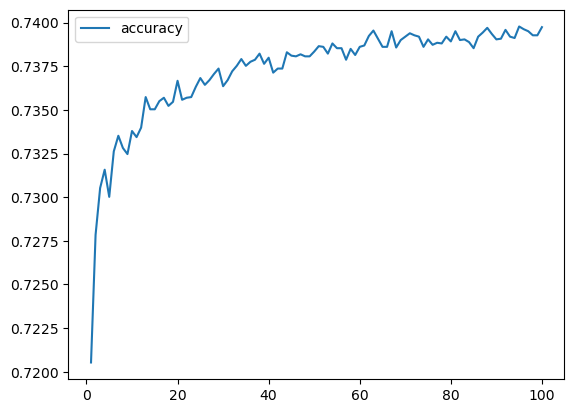

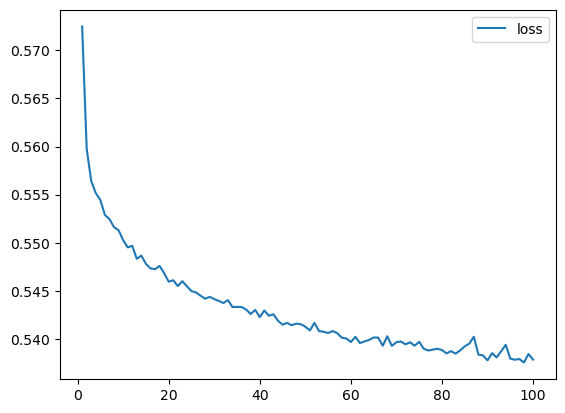

In [26]:
# Model accuracy history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
history_df.plot(y="accuracy")
history_df.plot(y="loss")

In [27]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")